In [1]:
# coding: utf-8

import xarray as xr
import numpy as np
from glob import glob
import sys
from datetime import datetime
from dateutil.relativedelta import relativedelta
import pickle
import calendar
import matplotlib.pyplot as plt
import cartopy
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import matplotlib.colors as cls
import matplotlib as mpl
import copy
import pandas as pd

In [2]:
# Opening a dataset just to get the lat/lon of the grid
aux1 = xr.open_dataset('/chinook/marinier/CONUS_2D/wrfout_invariants.nc', engine='netcdf4') 
xll, yll = aux1.XLONG.values[0, 0, 0],aux1.XLAT.values[0, 0, 0]
xur, yur = aux1.XLONG.values[0, -1, -1],aux1.XLAT.values[0, -1, -1]

In [3]:
df = pd.read_csv('stations.csv', index_col=0)

In [4]:
stations = df.loc[(df['9st'] == 'z') | (df['9st'] == 'y') | (df['9st'] == 'x')]

In [5]:
stations.head()

,ns,stnid,9st,St_Name,PR,Elev,Lat,Long,X,Y,offset,Time Zone,Unnamed: 12,Possibilities
0,1,1018620,z,VICTORIA INT'L A,BC,20,48.65,-123.43,9.836,16.737,-8.0,PST,NaN,"[4, 4, 4, 4, 4]"
2,3,1026270,z,PORT HARDY A,BC,22,50.68,-127.37,8.361,20.039,-8.0,PST,NaN,"[4, 4, 4, 4, 4]"
5,6,1098940,z,WILLIAMS LAKE A,BC,940,52.18,-122.05,12.364,19.873,-8.0,PST,NaN,"[2, 2, 2, 2, 2]"
7,8,1108447,x,VANCOUVER INT'L A,BC,4,49.20,-123.18,10.259,17.210,-8.0,PST,NaN,"[4, 4, 4, 4, 4]"
9,10,1152102,z,CRANBROOK A,BC,940,49.61,-115.78,15.385,15.632,-7.0,MST,NaN,"[2, 2, 2, 2, 2]"


In [23]:
stations['Lat'].values

array([48.65, 50.68, 52.18, 49.2 , 49.61, 50.7 , 53.32, 51.11, 55.18,
       54.42, 50.43, 52.17, 55.15, 49.91, 49.92, 53.97, 55.8 , 49.79,
       48.37, 46.48, 49.41, 46.36, 45.32, 42.28, 43.68, 46.8 , 45.47,
       50.22, 48.78, 48.6 , 48.33, 48.22, 53.63, 55.28, 45.87, 44.88,
       43.83, 46.29, 52.93])

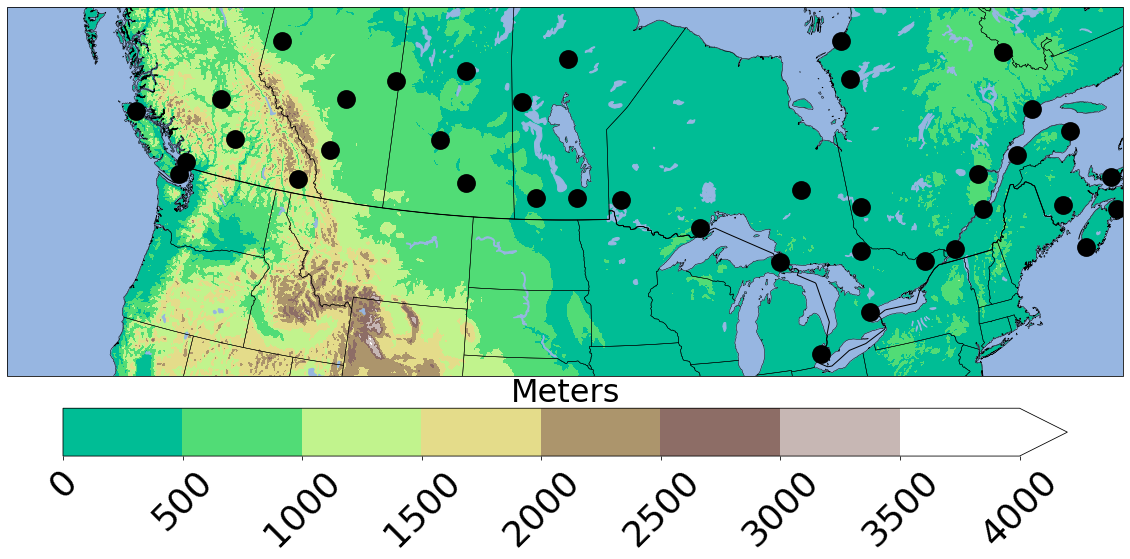

In [9]:
# How much of the PGW values at -4C come from: -4C in CTRL
# total_m4PGW_m4CTRL / total_pgw_minus4

myLambert = ccrs.LambertConformal(central_longitude=-98.0, central_latitude=39.700012)

  # Making the subplots
f, ax = plt.subplots(1, 1, figsize=(20, 12), subplot_kw={'projection': myLambert})

width = 1.0  
#new_cmap = copy.copy(mpl.cm.get_cmap("viridis_r"))
#new_cmap.set_bad(color='white')

val_max = 4000 #np.max(aux1['total_day'].values)
val_min = 0
val_int = 500
orig_cmap = plt.cm.terrain
clrs = orig_cmap(np.linspace(0.22, 1, 256))
new_cmap = cls.LinearSegmentedColormap.from_list("terrain", clrs)
#cmap = plt.get_cmap('jet')
#new_cmap = truncate_colormap(cmap, 0, 1)

unit = "Meters"
#title = r"% of the -4${\rm ^\circ C}$ in PGW that comes from the -4${\rm ^\circ C}$ bin in CTRL"
title = ""
ax.set_extent([xll-6.6, xur-9.65, 38, yur+2])
#ax.set_extent([xll-7.6, xur-8.5, 36, yur+2.4])

ints = ( (val_max-val_min+val_int) / val_int)
color_bnds  = np.linspace(val_min, val_max, int(ints))
color_ticks = np.linspace(val_min, val_max, int(ints))

norm = cls.BoundaryNorm(boundaries=color_bnds, ncolors=256)
# Plot figure
cs = ax.pcolormesh(aux1['XLONG'].values[0], aux1['XLAT'].values[0], aux1['HGT'].values[0], transform=ccrs.PlateCarree(),
                cmap=new_cmap, vmin=val_min, vmax=val_max, norm=norm)

# Plot colorbar
cb = f.colorbar(cs, ax=ax, ticks=color_ticks,orientation="horizontal",pad=0.05,shrink=0.9, extend="max")        
cb.ax.set_title(unit, fontsize=32)
cb.ax.tick_params(labelsize=36, labelrotation=45)

plt.scatter(x=stations['Long'].values, y=stations['Lat'].values, c='black', s=250, 
            edgecolor='black', lw=3, transform=ccrs.PlateCarree(), zorder=3)
        
ax.set_title(title, fontsize=28)

ax.coastlines(resolution='10m', linewidth=width, zorder=1)
ax.add_feature(cfeature.BORDERS.with_scale("10m"), linewidth=width, zorder=2)
ax.add_feature(cfeature.STATES.with_scale("10m"), linewidth=width/2, zorder=2)
ax.add_feature(cfeature.OCEAN, zorder=1)
ax.add_feature(cfeature.LAKES, zorder=1)

plt.savefig('topography_cities.png', facecolor='white', bbox_inches='tight')
plt.show()